In [1]:
# usa el archivo en formato wide que contiene fraudes y no fraudes (generado por la notebook: create_fraud_normal_format)

In [109]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
# import boto3
# import pandas as pd
# import io

# from sklearn.impute import KNNImputer
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# # from boruta import BorutaPy
# from sklearn.feature_selection import mutual_info_classif
# from lightgbm import LGBMClassifier, early_stopping, Dataset,log_evaluation
# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform
# from imblearn.pipeline import Pipeline, make_pipeline
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc, average_precision_score
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks
# from collections import Counter
# from sklearn.calibration import CalibratedClassifierCV,calibration_curve
# from tqdm import tqdm
# from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import tempfile

# from imblearn.over_sampling import RandomOverSampler
# import catboost as cb
# import joblib
# from sklearn.model_selection import train_test_split


In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [76]:
from src.preprocessing.preprocessing  import data_wrangling
from src.modeling.supervided_models import LGBMModel, NNModel, LSTMNNModel, CATModel

In [77]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) #evita mostrar notacion cientifica

In [78]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

In [79]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([0,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def get_feature_sel_method(method,periodo):
    if  method=='corr':
        return pd.read_csv(f'{DATA_PATH}/features_by_corr_{periodo}.csv')['0'].tolist()
    elif method == 'boruta1':
        return pd.read_csv(f'{DATA_PATH}/features_by_const_boruta_{periodo}.csv')['0'].tolist()
    elif method == 'boruta2':
        return pd.read_csv(f'{DATA_PATH}/features_by_const_boruta2_{periodo}.csv')['0'].tolist()
    elif method == 'mi':
        return pd.read_csv(f'{DATA_PATH}/features_by_const_mi_{periodo}.csv')['0'].tolist()
    else:
        return pd.read_csv(f'{DATA_PATH}/features_by_constante_{periodo}.csv')['0'].tolist()
        

In [80]:
seed = 2021
np.random.seed(seed)

## Parametros

In [81]:
DATA_PATH = 'tmp/'

In [82]:
# test parameters
param_fe_sel = 'boruta'
param_imb_method = 'under'
periodo = 12
preprocesor = 3
sam_th = 0.5

In [83]:
print("parametros :",param_fe_sel,param_imb_method,periodo,preprocesor)

parametros : boruta under 12 3


## Leer Archivos

In [84]:
print("Read data - Inicio")

Read data - Inicio


In [85]:
df = pd.read_parquet(DATA_PATH+'df_tsfel_variables.parquet')

In [86]:
df.rename(columns={'id_usuario':'uc'}, inplace=True)
df.rename(columns={'id':'index'}, inplace=True)
df.rename(columns={'is_fraud':'target'}, inplace=True)

In [87]:
df.head()

uc  12_anterior  11_anterior  10_anterior  9_anterior  8_anterior  \
0   100035       153.00       125.00       117.00      120.00      128.00   
1   100043       253.00       246.00       259.00      262.00      254.00   
2    10008       187.00         0.00       205.00      187.00      178.00   
3  1000912       657.00       576.00       636.00      595.00      659.00   
4  1000996        70.00        61.00        61.00       69.00       85.00   

   7_anterior  6_anterior  5_anterior  4_anterior  3_anterior  2_anterior  \
0       80.00      105.00      123.00      101.00      111.00       99.00   
1      184.00      188.00      189.00      201.00      204.00      189.00   
2      194.00      200.00      188.00      168.00        0.00        0.00   
3      598.00      616.00      657.00      613.00      613.00      633.00   
4       97.00       96.00       95.00      100.00      104.00       90.00   

   1_anterior date_fizcalizacion  cant_ttarifa departamento  \
0       96.00         2022-01-01             1    guatemala   
1      188.00         2022-01-01             1    guatemala   
2       26.00         2022-01-01             1    guatemala   
3      616.00         2022-01-01             1    guatemala   
4       76.00         2022-01-01             1    guatemala   

            municipio     zona tipo_tarifa contrato       date  cod_mat  \
0         villa_nueva   zona_3          TS   100035 2022-01-01  41-0069   
1           guatemala   zona_4          TS   100043 2022-01-01  41-0081   
2           guatemala  zona_10          TS    10008 2022-01-01  41-0083   
3               mixco   zona_4         TNS  1000912 2022-01-01  41-0083   
4  san_jose_del_golfo   zona_0          TS  1000996 2022-01-01  41-0084   

   target  cant_null  eliminar unidad_de_lectura codigo_postal fecha_de_alta  \
0       0          0         0           708-008          1064    2001-07-11   
1       0          0         0           605-015          1004    2001-07-06   
2       0          0         0           603-001          1010    2001-07-04   
3       0          0         0           612-039          1057    2008-07-24   
4       0          0         0           813-035          1053    2008-07-24   

  no_de_poste tarfia  multiplicador actividad_economica  kw_cont  \
0      238366    R11           1.00              83_009     0.00   
1      135771    C11           1.00              85_009     0.00   
2      107349    C11           1.00              83_002     0.00   
3      518933    C11           1.00              49_005     0.00   
4      386109    R11           1.00              83_009     0.00   

  medidor_interior          folio  nivel_de_tension  index  \
0         sin_dato  708-10329-000              2.00      0   
1         sin_dato  605-11884-000              2.00      1   
2                X  603-02018-000              2.00      2   
3         sin_dato  612-53632-000              2.00      3   
4         sin_dato  813-61192-000              2.00      4   

   0_ECDF Percentile Count_0  0_ECDF Percentile Count_1  0_ECDF Percentile_0  \
0                       2.00                       9.00                96.00   
1                       2.00                       9.00               188.00   
2                       2.00                       9.00                 0.00   
3                       2.00                       9.00               595.00   
4                       2.00                       9.00                61.00   

   0_ECDF Percentile_1  0_ECDF_0  0_ECDF_1  0_ECDF_2  0_ECDF_3  0_ECDF_4  \
0               123.00      0.08      0.17      0.25      0.33      0.42   
1               253.00      0.08      0.17      0.25      0.33      0.42   
2               188.00      0.08      0.17      0.25      0.33      0.42   
3               636.00      0.08      0.17      0.25      0.33      0.42   
4                96.00      0.08      0.17      0.25      0.33      0.42   

   0_ECDF_5  0_ECDF_6  0_ECDF_7  0_ECDF_8  0_ECDF_9

In [88]:
df.shape

(30932, 207)

In [89]:
print("Read data - Fin")

Read data - Fin


## Data Wrangling

In [90]:
%%time
df = data_wrangling(df,periodo)

CPU times: user 566 ms, sys: 120 ms, total: 686 ms
Wall time: 682 ms


## Particionar dataset

In [91]:
df = df.sample(frac=1.0)

In [92]:
#Particionar por fecha
df_train = df[df.date_fizcalizacion<='2022-02-01'].copy()
y_train = df_train.target.copy()
df_train = df_train.drop(columns=['target'])

df_val = df[df.date_fizcalizacion.between('2022-03-01','2022-03-01')].copy()
y_val = df_val.target.copy()
df_val = df_val.drop(columns=['target'])

df_test = df[df.date_fizcalizacion>'2022-03-01'].copy()
y_test = df_test.target.copy()
df_test = df_test.drop(columns=['target'])

In [93]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(15525, 206)
(8659, 206)
(6748, 206)


In [94]:
print(100*y_train.value_counts(normalize=True))
print(100*y_val.value_counts(normalize=True))
print(100*y_test.value_counts(normalize=True))

0   99.09
1    0.91
Name: target, dtype: float64
0   99.38
1    0.62
Name: target, dtype: float64
0   99.04
1    0.96
Name: target, dtype: float64


## Feature selection

In [95]:
print('Feature Selection : Inicio')

Feature Selection : Inicio


In [96]:
feauture_selected = get_feature_sel_method(param_fe_sel,periodo)
len(feauture_selected)

149

In [97]:
cols_consumo = [f'{i}_anterior' for i in range(periodo, 0, -1)]
cols_uc = ['departamento','codigo_postal','actividad_economica','tipo_tarifa','tarfia','nivel_de_tension','cod_mat','cant_ttarifa','medidor_interior']

In [98]:
cols_for_model = cols_uc+cols_consumo+feauture_selected

In [99]:
print('Feature for models : ', df_train[cols_for_model].shape)

Feature for models :  (15525, 170)


In [100]:
print('Feature Selection : Fin')

Feature Selection : Fin


# Models

In [101]:
resulado_final = {}

## LGBM

In [102]:
%%time
train_lgbm_model = LGBMModel(cols_for_model,hyperparams=None,search_hip=True,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
lgbm_model = train_lgbm_model.train(df_train,y_train,df_val, y_val)


Best score reached: 0.6680891171817086 with params: {'lgbmclassifier__colsample_bytree': 0.4886705267429202, 'lgbmclassifier__learning_rate': 0.016333514000872486, 'lgbmclassifier__max_bin': 158, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__min_child_samples': 118, 'lgbmclassifier__min_child_weight': 0.1, 'lgbmclassifier__num_leaves': 22, 'lgbmclassifier__reg_alpha': 0, 'lgbmclassifier__reg_lambda': 5, 'lgbmclassifier__scale_pos_weight': 1, 'lgbmclassifier__subsample': 0.8945613420997809, 'lgbmclassifier__subsample_freq': 18} 
CPU times: user 16.7 s, sys: 356 ms, total: 17.1 s
Wall time: 4.85 s


In [103]:
y_pred_test_lgbm = lgbm_model.predict_proba(df_test[cols_for_model])[:,1]
resulado_final[f'{param_imb_method}-lgbm'] = y_pred_test_lgbm

In [105]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lgbm))

AUC Test:  0.697


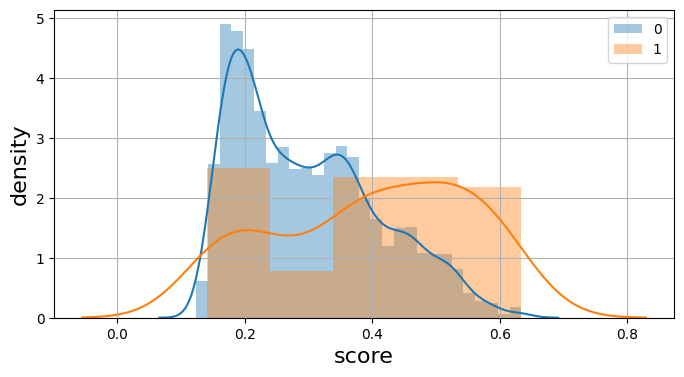

In [113]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lgbm[y_test==0], label='0')
sns.distplot(y_pred_test_lgbm[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## CAT-BOOST

In [108]:
%%time
train_cat_model = CATModel(cols_for_model,hyperparams=None,search_hip=True,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
cb_model = train_cat_model.train(df_train,y_train,df_val, y_val)


Best score reached: 0.7529714486451798 with params: {'catboostclassifier__bagging_temperature': 100, 'catboostclassifier__border_count': 254, 'catboostclassifier__depth': 7, 'catboostclassifier__l2_leaf_reg': 64.15849548912328, 'catboostclassifier__learning_rate': 0.06338024695026505} 
CPU times: user 2min 4s, sys: 31.3 s, total: 2min 35s
Wall time: 42min 32s


In [110]:
y_pred_test_cb = cb_model.predict_proba(df_test[cols_for_model])[:,1]
resulado_final[f'{param_imb_method}-catboost'] = y_pred_test_cb

In [111]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_cb))

AUC Test:  0.750


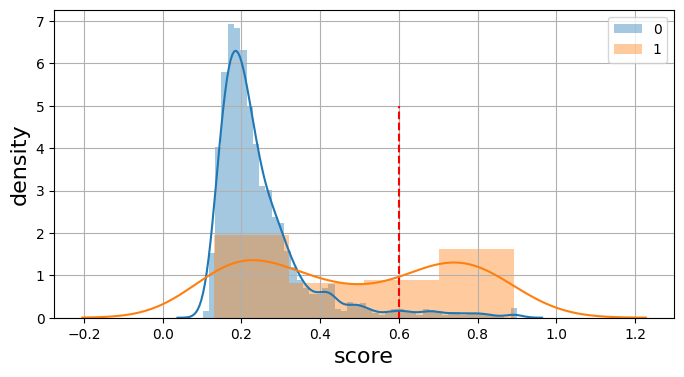

In [112]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_cb[y_test==0], label='0')
sns.distplot(y_pred_test_cb[y_test==1], label='1')
plt.vlines(0.6, ymin=0, ymax=5, color='red', linestyles='dashed')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## NN

In [114]:
%%time
features_names = cols_uc + feauture_selected
spents_names = cols_consumo
train_nn_model = NNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
rnn_model,pipe_features,pipe_spent = train_nn_model.train(df_train,y_train)

2022-12-17 15:12:25.870348: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 15:12:25.870384: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 15:12:25.870412: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (49434f55fd6e): /proc/driver/nvidia/version does not exist
2022-12-17 15:12:25.873216: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-17 15:12:25.906911: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400010000 Hz
2022-12-17 15:12:25.909653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55720354ba90 initialized for platform Host (this does not guarantee tha

Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
CPU times: user 8.71 s, sys: 1.27 s, total: 9.98 s
Wall time: 3.92 s


In [115]:
X_features = pipe_features.transform(df_test[features_names])
X_spents = pipe_spent.transform(df_test[spents_names])
X_test_features = np.concatenate([X_features,X_spents],axis=1)

In [116]:
y_pred_test_rnn = rnn_model.predict(X_test_features, batch_size=train_nn_model.BATCH_SIZE)
resulado_final[f'{param_imb_method}-ffn'] = y_pred_test_rnn

In [117]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_rnn))

AUC Test:  0.768


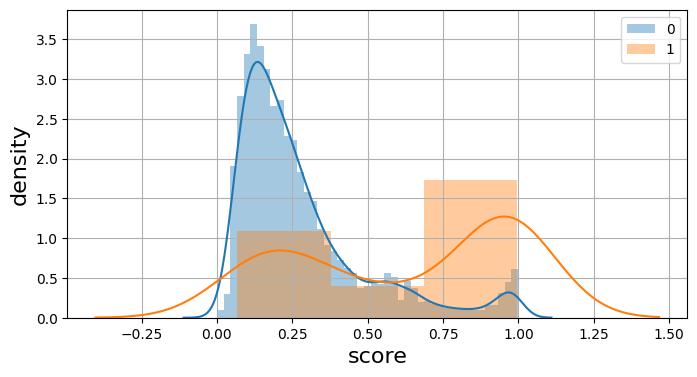

In [118]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## LSTM-NN

In [119]:
%%time
features_names = cols_uc + feauture_selected
spents_names = cols_consumo
lstm_nn_model = LSTMNNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
lstm_rnn_model,pipe_features,pipe_spent = lstm_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
CPU times: user 58.8 s, sys: 18.4 s, total: 1min 17s
Wall time: 10.9 s


In [120]:
X_test_features = pipe_features.transform(df_test[features_names])
X_test_spents = pipe_spent.transform(df_test[spents_names])
X_test_spents = X_test_spents.reshape((X_test_spents.shape[0],periodo,1))

In [121]:
y_pred_test_lstm_rnn = lstm_rnn_model.predict([X_test_spents, X_test_features],batch_size=lstm_nn_model.BATCH_SIZE)[:,0]
resulado_final[f'{param_imb_method}-lstm-ffn'] = y_pred_test_lstm_rnn

In [122]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lstm_rnn))

AUC Test:  0.740


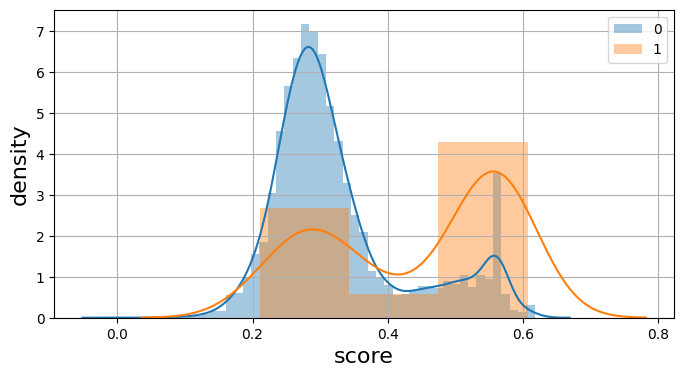

In [123]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lstm_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_lstm_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## Resultado Final

metodo  auc
2       under-ffn 0.77
1  under-catboost 0.75
3  under-lstm-ffn 0.74
0      under-lgbm 0.70

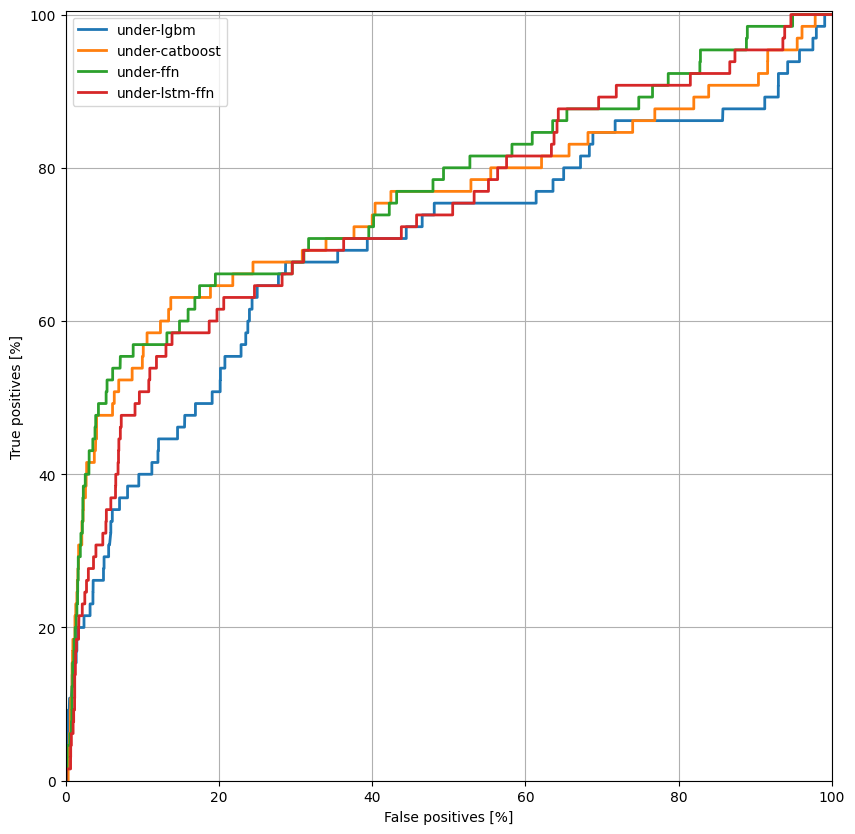

In [124]:
l_m_auc = []
for i,x in enumerate(resulado_final.keys()):
    plot_roc(x, y_test,resulado_final[x] , color=colors[i])
    m_auc = roc_auc_score(y_test,resulado_final[x])
    l_m_auc.append((x,m_auc))
plt.legend();

pd.DataFrame(l_m_auc, columns=['metodo','auc']).sort_values('auc',ascending=False)

In [130]:
print('FIN')

FIN


***